# Lithography Simulation with Python - Aberrations
In this notebook we will focus on the optical aberrations when modelling the aerial image.

## What are optical aberrations ?
In absence of aberrations a spherical wave keeps is spherical shape during its propagation through an optical system.
In reality no such system exists: there is always a perturbation of the wave front.
Aberrations describe the perturbation of a wave front that is not accounted when using geometrical optics.
There are two types of aberrations : the chromatic aberrations (that depends on the wavelength of the light) and the geometrical aberrations (that depend on the geometry of the optical system).

The most simple observation of an aberration is the Airy disk: the image of a point even by a perfect optical system is not a point. The size of the Airy disk is proportional to the wavelength of illumination (when using geometrical optics we assume that the wavelength is zero, thus the image of a point is indeed a point.). There exist a wide range of optical aberrations: coma, spherical, tilt... Every single aberration accounts for a specific deviation of the wave front. Most of the time, multiple aberrations exist at the same time.

## How aberrations are accounted for ?
In aerial image simulation, and more generally in Fourier optics, the aberration are described at the pupil plane of the imaging lens. This is quite understandable in a way: the aberrations "affect" the wave front during its propagation through the lens. In the case of lithography this imaging lens is the projection lens. Again, this is already an approximation because the projection optical system is actually composed of more than 40 lens! 

An aberration is a deviation from the ideal wave front, so the mathematical description of aberrations should account for this deviation. The Zernike polynomials are a description of the wavefront independent from the optical system. They describe all the possible aberrations at the pupil plane of the projection lens. The Zernike polynomials can be expressed by an aberration function $W(f)$ expressed at the pupil plane of the projection lens (in frequency space). The transfer function for the pupil function is re-written :
$$
\tilde{H}(f)=\begin{cases} e^{ikW(f)} & \text{if $|f|\leqslant \frac{\text{NA}}{\lambda}$} \\
0 & \text{otherwise} 
\end{cases}
$$
The number of Zernike functions is actually infinite. The first functions correspond to the aberrations described by Seidel one century ago.
### Defocus as an aberration
The defocus corresponds to an offset between the plane of focus and the plane of best focus.
In a real stepper, this corresponds to a vertical shift of the substrate relative to the plane of best focus.
Defocus is actually not an aberration, because the operator choose to apply it or not, but its effect can be treated at such.
For a vertical shift of $D$, the defocus aberration function is written:

$$W(f)=D\sqrt{1-f^2\lambda^2}$$

The defocus aberration affects the highest frequencies rather than the low frequencies.

## Numerical implementation of defocus
In this section we describe the implementation of the defocus aberration for the Abbe model.
To illustrate the impact of the defocus aberration we will use a line/space pattern with a pitch of 1µm and a 1:1 ratio.
The first steps are again to compute the mask transmission function and its corresponding Fourier Transform.

In [305]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})

### Mask creation and spectrum computation
We create a mask corresponding to an infine/line space with a pitch of 1µm and a 1:1 ratio.
The mask is composed of 3 spaces and 3 lines and is centered on a space (transmission of 1).
Remember that the Fourier Transform works with infinite signals, the way you define the mask is thus extremely important.
Like almost everything in Physics, be careful for the boundary conditions!

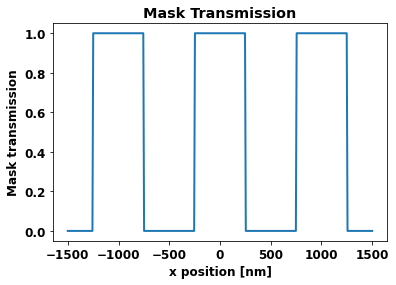

In [306]:
def line_space_msk(line_size,n_rep,nx):
    #Using Jupyter notebook the n_rep is set to float.
    #this cast it back to int. I don't know why, feel free to help.
    n_rep=int(n_rep)
    #Define the spatial support
    x_support=np.linspace(-line_size,line_size,nx)
    # Define the mask, 1 for glass, 0 for chromium
    # n_rep defines the mask repetition
    mask=[1 if np.abs(x)<line_size/2 else 0 for x in x_support]*n_rep
    # Update the support after mask multiplication
    nx*=n_rep
    x_support=np.linspace(-n_rep*line_size,n_rep*line_size,nx)
    dx=line_size*2*n_rep/nx
    return mask, x_support, dx, nx

mask, x_support, dx, nx=line_space_msk(line_size=500.,n_rep=3.,nx=128)
# Plot 
plt.title('Mask Transmission',fontweight='bold')
plt.plot(x_support,mask,linewidth=2)
plt.xlabel('x position [nm]',fontweight='bold')
plt.ylabel('Mask transmission',fontweight='bold')
plt.show()

We compute the mask Fourier Transform with the numeric Fourier Transform.
Remember that we could compute an analytic Fourier Transform here.

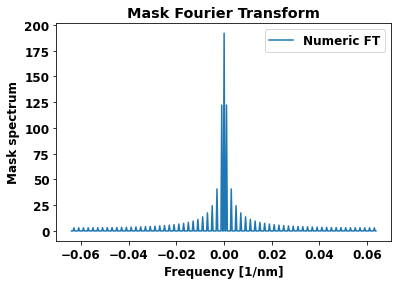

In [307]:
# Computation of the mask TF and its frequency support
mask_ft=np.fft.fftshift(np.fft.fft(mask))
# Do not forget the pixel size d when creating the frequency support
freq_support=np.fft.fftshift(np.fft.fftfreq(nx,d=dx))
# Plotting section
plt.title('Mask Fourier Transform',fontweight='bold')
plt.plot(freq_support,np.abs(mask_ft),label='Numeric FT')
plt.legend()
plt.xlabel('Frequency [1/nm]',fontweight='bold')
plt.ylabel('Mask spectrum',fontweight='bold')
plt.show()

### Implementation of the defocus function
The defocus function is implemented in the *compute_defocus* function below.

In [308]:
def compute_defocus(defocus ,wavelength, freqx):
    #Compute the wave vector for the current wavelength.
    k = 2 * np.pi / wavelength
    # Compute the defocus aberration function.
    defocus_aberration=defocus * np.sqrt(1 - (wavelength * freqx) ** 2)
    aberration_function = np.exp(1j * k * defocus_aberration)
    return aberration_function

The defocus aberration function is added during the computation of the aerial image with the Abbe model described in the previous notebook. The defocus aberration is directy computed when computing the pupil transfer function.

In [309]:
def compute_abbe(sigma, NA, wavelength, defocus, mask_ft, frq):
    # Define the effective source points of the circular source
    source_points=[f for f in frq if np.abs(f)<=sigma*NA/wavelength]
    # Initialisation of the aerial image as single precision
    aerial_image=np.zeros_like(mask_ft,dtype='float32')
    # Compute all source points contribution to the aerial image
    for freq_src in source_points:
        # Shift of the frequency support relative to the current source point frequency
        freq_msk_shft = [(f - freq_src) for f in frq]
        # Shifted transfer function of the projection lens with defocus aberration
        pupil_shifted = [compute_defocus(defocus,wavelength,f)  if np.abs(f) <= NA/wavelength 
                         else 0 for f in freq_msk_shft]
        # Compute the complete contribution 
        mask_lpf = np.multiply(mask_ft, pupil_shifted)
        # Add the contribution of the current src point to the overall aerial image
        aerial_image += np.abs(np.fft.ifft(mask_lpf)) ** 2
    # Normalisation with number of source points
    return aerial_image/len(source_points)

## Impact of defocus on the aerial image.
In this section we illustrate the impact of defocus on the mask defined previously.
This mask has been chosen because a similar work has been done by C. Mack and is illustrated on the Figure below:
<img src="img/focus_line_space.PNG" width="500" />

Source:
- [Mack, C. A. (1993). *Understanding focus effects in submicrometer optical lithography: a review.* Optical Engineering, 32(10), 2350-2363.](https://www.spiedigitallibrary.org/journals/optical-engineering/volume-32/issue-10/0000/Understanding-focus-effects-in-submicrometer-optical-lithography-a-review/10.1117/12.146837.short?SSO=1)

Let's see if we can find the same result.

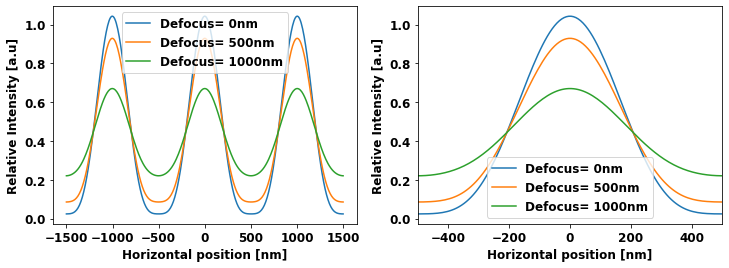

In [310]:
#Figure creation
fig,ax=plt.subplots(1,2,figsize=(12,4))
#Loop over all defocus values
for defocus in [0, 500, 1000]:
    # Compute the aerial image at the given defocus.
    int_profile=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,defocus=defocus,mask_ft=mask_ft,frq=freq_support)
    # Plot the intensity profile on two subplots
    ax[0].plot(x_support,int_profile,label=f'Defocus= {defocus}nm')
    ax[1].plot(x_support,int_profile,label=f'Defocus= {defocus}nm')

#Limit the x limits to match the article above.
ax[1].set_xlim(-500.,500.)
# Add axis decorators.
for ax in ax:
    ax.legend()
    ax.set_ylabel('Relative Intensity [a.u]',fontweight='bold')
    ax.set_xlabel('Horizontal position [nm]',fontweight='bold')

Our simulation results match the article. **The defocus in an even function.**

## Bulk image computation with scaled defocus

The defocus of the aerial image is not only something you can change by setting the stepper parameters.
Defocus happens when the aerial image propagates into the resist thickness.
In the previous Notebook, this effect has not been taken into account.

Computing the bulk image while taking into account the defocus of the aerial image can be done using the scaled defocus algorithm. The defocus of the aerial image is scaled by the optical index of the resist during its propagation in the resist. This scaled defocus is expressed as follows :

$$D_{sc}=\frac{z}{n_{resist}}-D_{stepper}$$
- $D_{stepper}$ is the defocus of the stepper (a setting)
- $z$ is vertical position in the resist ($z=0$ is the resist surface)
- $n_{resist}$ is the real part of the resist optical index.

<font color=red>**In our convention a positive defocus means the aerial image is projected into the resist whereas a negative defocus means the aerial image is projected above the resist.**</font>

The scaled defocus is an extension of the vectorial approach and is useful to work with the simple scalar diffraction theory. Be sure to check if your equipement/process is adequate and can be modeled using the scalar diffraction theory before using it.

Source:
- [Bernard, D. A. (1988). *Simulation of focus effects in photolithography*. IEEE Transactions on Semiconductor Manufacturing, 1(3), 85-97.](https://ieeexplore.ieee.org/abstract/document/4379/?casa_token=pw_oE3teu5oAAAAA:TSSsB1I7I3yllWrm93y2Cl62H78mOpPpsK7IOlDw908U4GafjtpB7rYDFSn0wI8dkVgnYrs6Frc)

The bulk image was previously computed without the scaled defocus:
$$ I(x,y,z,D_{stepper})=I(x,y,D_{stepper})e^{-\alpha z}$$
If the scaled defocus is used, the bulk image is written:
$$ I(x,y,z,D_{stepper})=I\left(x,y,D_{stepper}-\frac{z}{n_{resist}}\right)e^{-\alpha z}$$

From the two formulations we can already understand that the computation time for the scaled defocus will be longer.
The scaled defocus require to compute as many aerial image as there are "slices" along the $z$ axis whereas the conventional approach only requires one aerial image to be computed.

Both functions are implemented below:

In [311]:
def compute_expo(stepper_defocus,thickness,dz,alpha=0.0005):
    #Compute the aerial image on top of the stack
    aerial_image=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,
                              defocus=stepper_defocus,mask_ft=mask_ft,
                              frq=freq_support)
    # Create a meshgrid corresponding to the resist coordinates in x and z direction
    nz=int(thickness/dz)
    z=np.linspace(0,thickness,nz)
    X,Z=np.meshgrid(x_support,z)
    # Bulk image computation without scaled defocus 
    aerial_image_no_defocus=np.stack([aerial_image for _ in range(nz)])
    #Stack the aerial image on itself
    bulk_ini=np.stack(aerial_image,0)
    # Apply vertical absorption
    bulk_img=bulk_ini*np.exp(-alpha*Z)
    
    return bulk_img

def compute_expo_scaled_defocus(stepper_defocus,thickness,dz,alpha=0.0005):
    #Compute the aerial image on top of the stack
    aerial_image=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,
                              defocus=stepper_defocus,mask_ft=mask_ft,
                              frq=freq_support)
    # Create a meshgrid corresponding to the resist coordinates in x and z direction
    nz=int(thickness/dz)
    z=np.linspace(0,thickness,nz)
    X,Z=np.meshgrid(x_support,z)
    # Optical index of the resist
    n_resist=1.5+1j*0.023
    #Compute all scaled z positions inside the resist thickness
    #The first position is not zero because it is already computed in aerial_image
    defocus_positions = np.arange(dz / np.real(n_resist)-stepper_defocus, 
                                  thickness / np.real(n_resist)-stepper_defocus,
                                  dz / np.real(n_resist))
    #Loop over all positions to compute the bulk image
    for defocus in defocus_positions:
        int_z=compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,defocus=defocus,
                           mask_ft=mask_ft,frq=freq_support)
        aerial_image=np.vstack((aerial_image,int_z))
    # Apply vertical absorption
    bulk_img=aerial_image*np.exp(-alpha*Z)

    return bulk_img, X, Z

Now, we compute the initial bulk image with both formulations to see the difference.
We choose a defocus of 1000nm, meaning that the aerial image is projected into the photoresist film.

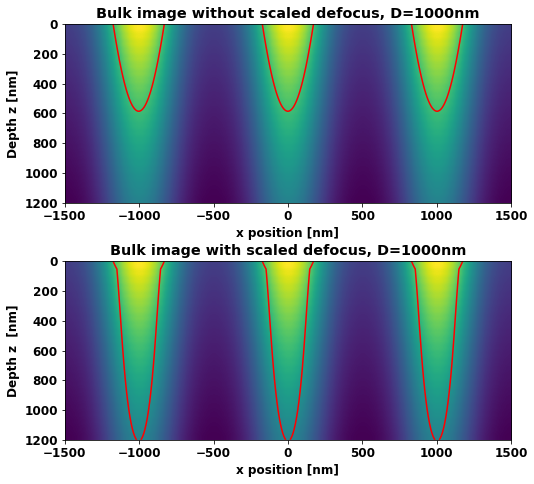

In [312]:
# Set defocus
stepper_defocus=1000
# Set resist thickness in nm
thickness=1200.
# Set pixel size along z direction
dz=50.
#Compute bulk image without scaled defocus
bulk_img_no_defocus=compute_expo(stepper_defocus,thickness,dz)
#Compute bulk image with scaled defocus
bulk_img_defocus,X, Z=compute_expo_scaled_defocus(stepper_defocus,thickness,dz)

# Plotting section
fig,ax=plt.subplots(2,1,figsize=(8,8))
ax[0].imshow(bulk_img_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[0].contour(X,Z,bulk_img_no_defocus,levels=[0.5],colors='r')
ax[0].set_xlabel('x position [nm]',fontweight='bold')
ax[0].set_ylabel('Depth z [nm]',fontweight='bold')
ax[0].set_title(f'Bulk image without scaled defocus, D={stepper_defocus}nm',fontweight='bold')
#With Scaled defocus
ax[1].imshow(bulk_img_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[1].contour(X,Z,bulk_img_defocus,levels=[0.5],colors='r')
ax[1].set_xlabel('x position [nm]',fontweight='bold')
ax[1].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[1].set_title(f'Bulk image with scaled defocus, D={stepper_defocus}nm',fontweight='bold')
plt.show()

The red contours on the images represent the boundary between the regions of the bulk image greater than 0.5 from the regions lower than 0.5. This helps in understanding the defocus effect.

If the defocus is not taken into account (top image), the aerial image on top of the photoresist is computed with the correct defocus and only undergoes absorption as it propagates down. The intensity is quickly vanishing.

On the other hand, with the scaled defocus, the aerial image contrast increases as it propagates down (because the aerial image is getting closer to its plane of best focus) in the photoresist which counterbalances the absorption effect. This result in higher light intensity in the photoresist film.

Note that this effect works in the other way around. If the defocus is negative, let say -1000nm, the aerial image is projected above the photoresist. The first graph would look exactly the same. However, the intensity with the scaled defocus algorithm would vanish even faster. Indeed the defocus would increase as the aerial image propagates down. The loss in contrast due to this effect would add up to the absorption.

I strongly recommend to try changing the defocus and see the effect by yourself.

## Exposition
The function that computes the expostion does not change in comparison to the first Jupyter Notebook.
The same Dill coefficients are used and the dose is set to 1700 J/m².

In [313]:
def compute_exposition(bulk_ini,dose=1700.):
    # Initialise latent image
    lat_img=np.ones_like(bulk_ini)
    # Instanciate resist parameters A in [1/nm], A in [1/nm] and C in [m²/J]
    dill_a=0.00075
    dill_b=0.00005
    dill_c=0.0025
    # Typical lamp power in W/m²
    lamp_power=30000
    # Exposure time in s
    t_tot=dose/lamp_power
    n_steps=50
    # Discretize exposure time
    time_step=t_tot/n_steps
    #Copy the initial bulk image to start iteration
    bulk_img=bulk_ini.copy()
    # Loop to compute exposition
    for n in range(n_steps):
        # Latent image update
        lat_img*=np.exp(-dill_c*bulk_img*time_step*lamp_power)
        # Absorption coefficient update
        alpha=dill_a*lat_img+dill_b
        # Bulk image update
        bulk_img=bulk_ini*np.exp(-alpha*Z)
    
    return lat_img,bulk_img

## Development

### Mack development function
The Mack development function is used again.

In [314]:
# This function computes the developement rate according to the 4 parameters model from Mack.
def Mack_Developement_Rate(latent_img, m_th, r_min, r_max, n):
    a_mack = (1 - m_th) ** n
    a_mack *= (n + 1) / (n - 1)
    dev_rate = (a_mack + 1) * (1 - latent_img) ** n
    dev_rate /= a_mack + (1 - latent_img) ** n
    dev_rate *= r_max
    dev_rate += r_min
    dev_rate = np.clip(dev_rate, r_min, r_max)
    return dev_rate

### Fast Marching 
The fast marching is used to correctly account for the 3D development of the resist.

In [315]:
import skfmm
def compute_development(lat_img, dev_rate):
    # Fast Marching require a negative frontier to compute travel time
    # We add this frontier artifically (it will be removed later)
    neg_layer = -1 * np.ones_like(lat_img[0, :])
    lat_img = np.vstack((lat_img, neg_layer))
    cur_dev_rate = np.vstack((neg_layer, dev_rate))
    # Compute fast marching (! the algorithm flips the array along axis 0)
    time_resist_fmm = skfmm.travel_time(lat_img, cur_dev_rate, dx=[dz, dx],periodic=[False,True])
    # Remove artificial negative layer
    time_resist_fmm=time_resist_fmm[1:,:]
    # Flip array back to normal
    time_resist_fmm=np.rot90(time_resist_fmm,k=2)
    return time_resist_fmm

## Resist profiles with and without Scaled Defocus

Everything is set up and ready. We can now compute the exposition and the development of the photoresist and compare the results.

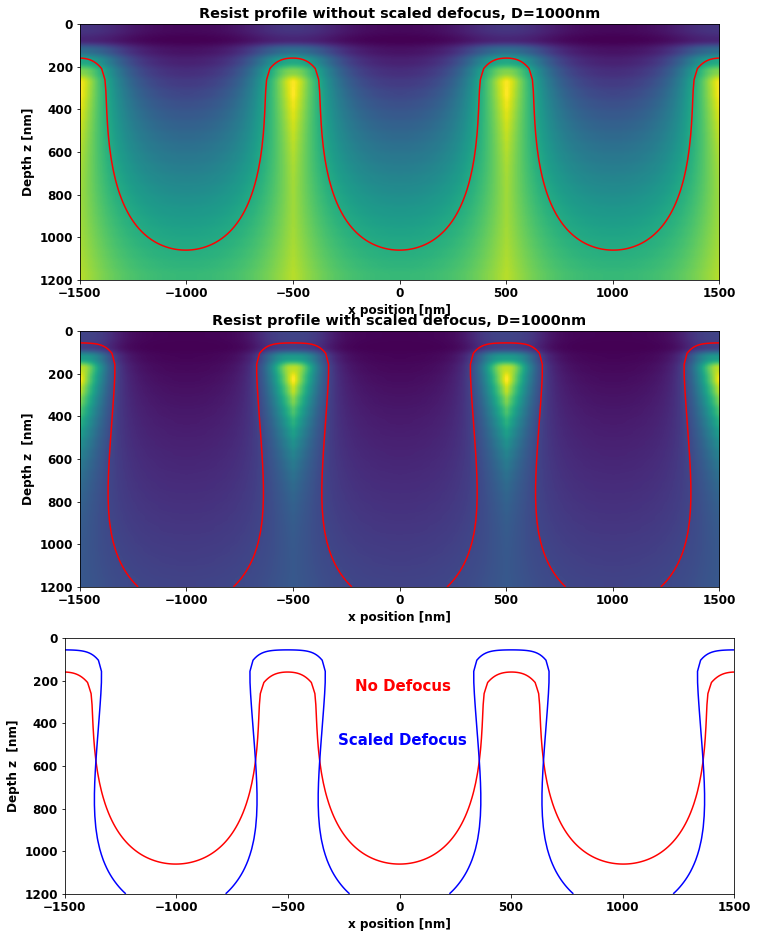

In [316]:
#Compute the final latent images with and without scaled defocus
lat_img_no_defocus,_=compute_exposition(bulk_img_no_defocus)
lat_img_defocus,_=compute_exposition(bulk_img_defocus)
#Compute the dev rate functions with Mack model
dev_rate_no_defocus=Mack_Developement_Rate(latent_img=lat_img_no_defocus, m_th=0.01, r_min=0.8, r_max=50, n=2)
dev_rate_defocus=Mack_Developement_Rate(latent_img=lat_img_defocus, m_th=0.01, r_min=0.8, r_max=50, n=2)
# Compute the resist development.
time_no_defocus=compute_development(lat_img_no_defocus,dev_rate_no_defocus)
time_defocus=compute_development(lat_img_defocus,dev_rate_defocus)
# Plotting section
fig,ax=plt.subplots(3,1,figsize=(12,16))
ax[0].imshow(time_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[0].contour(X,Z,time_no_defocus,levels=[30.],colors='r')
ax[0].set_xlabel('x position [nm]',fontweight='bold')
ax[0].set_ylabel('Depth z [nm]',fontweight='bold')
ax[0].set_title(f'Resist profile without scaled defocus, D={stepper_defocus}nm',fontweight='bold')
#With Scaled defocus
ax[1].imshow(time_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[1].contour(X,Z,time_defocus,levels=[30.],colors='r')
ax[1].set_xlabel('x position [nm]',fontweight='bold')
ax[1].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[1].set_title(f'Resist profile with scaled defocus, D={stepper_defocus}nm',fontweight='bold')
# Both profiles on same graph
ax[2].contour(X,Z,time_no_defocus,levels=[30.],colors='r')
ax[2].contour(X,Z,time_defocus,levels=[30.],colors='b')
ax[2].set_xlabel('x position [nm]',fontweight='bold')
ax[2].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[2].text(-200, 250, 'No Defocus',color='r',weight='bold',size=15)
ax[2].text(-275, 500, 'Scaled Defocus',color='b',weight='bold',size=15)
ax[2].set_xlim(np.min(x_support) , np.max(x_support))
ax[2].set_ylim(thickness ,0)
plt.show()

We can see that the impact of defocus cannot be ignored. 

We can see an interesting effect of using a negative defocus here.
On the blue profile the resist is getting thinner around 1000nm. This is normal because this corresponds to the region where the aerial image is being projected, the light intensity is high there and drives the resist development.

# Conclusion

In this Notebook we have seen:

- The implementation of optical aberrations when computing the aerial image.
- The defocus has been implemented and its effect on the resist profile investigated.

In the next Notebook we will adress:

- Effect of standing waves and how to simulate them.

In [317]:
# Code to automatically center the matplotlib figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")